Epoch 1/10, Loss: 0.3118, Train Acc: 0.8972, Test Acc: 0.8994
Epoch 2/10, Loss: 0.2312, Train Acc: 0.9619, Test Acc: 0.9693
Epoch 3/10, Loss: 0.2182, Train Acc: 0.9698, Test Acc: 0.9770
Epoch 4/10, Loss: 0.2132, Train Acc: 0.9739, Test Acc: 0.9751
Epoch 5/10, Loss: 0.2096, Train Acc: 0.9765, Test Acc: 0.8602
Epoch 6/10, Loss: 0.2004, Train Acc: 0.9815, Test Acc: 0.9808
Epoch 7/10, Loss: 0.1995, Train Acc: 0.9813, Test Acc: 0.9703
Epoch 8/10, Loss: 0.2000, Train Acc: 0.9854, Test Acc: 0.9636
Epoch 9/10, Loss: 0.1972, Train Acc: 0.9849, Test Acc: 0.9789
Epoch 10/10, Loss: 0.1939, Train Acc: 0.9863, Test Acc: 0.9761


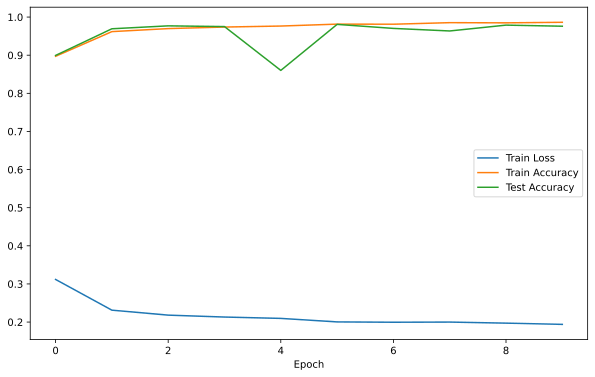

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_data = datasets.ImageFolder('E:/HuaweiMoveData/Users/dg145/Desktop/chest_xray/train', transform=transform)
test_data = datasets.ImageFolder('E:/HuaweiMoveData/Users/dg145/Desktop/chest_xray/test', transform=transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

class BinaryResidual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.linear = nn.Linear(num_channels * 96 * 96, 2)  

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        Y = Y.view(Y.size(0), -1) 
        Y = self.linear(Y)
        return F.relu(Y)


class BinaryResNet(nn.Module):
    def __init__(self):
        super(BinaryResNet, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*resnet_block(64, 128, 2))
        self.b4 = nn.Sequential(*resnet_block(128, 256, 2))
        self.b5 = nn.Sequential(*resnet_block(256, 512, 2))

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(512, 2)  

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.adaptive_pool(X)
        X = self.flatten(X)
        X = self.linear(X)
        return F.relu(X)

binary_resnet = BinaryResNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
binary_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(binary_resnet.parameters(), lr=0.05)

train_loss_history = []
train_acc_history = []
test_acc_history = []


num_epochs = 10
for epoch in range(num_epochs):
    binary_resnet.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = binary_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_history.append(avg_loss)
    train_acc_history.append(train_accuracy)

   
    binary_resnet.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = binary_resnet(val_images)
            _, preds = torch.max(val_outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        test_acc_history.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {val_accuracy:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


